# Linear Regression

1. The Ordinary Least Square method is very sensitive to the outliers. As the error increases quadratically, due to the existance of outliers, the OLS fitted line deviates from the majority of the data points.We can clearly see the line is aligned towards the outliers.

2. Scheme 1 will be better. We need to reduce the impact of outliers on the calculation of loss. 
Therefore we need to multiply the loss caused by outliers by a scalar significantly less than what we use for inliers. Therefore using $a_i=0.01$ for outliers and $a_i = 1 $ for inliers is preffered.  
On the other hand if we consider the scheme 2, multiplying outliers by larger value boost the impact of outliers for the loss function and makes the loss function more sensitive to the outliers.

3. Linear regression is unsuitable for this brain region analysis because it cannot handle the high-dimensional data where the number of brain regions (features) often exceeds or approaches the number of observations, leading to overfitting and unstable solutions. Additionally, brain regions exhibit strong multicollinearity due to functional connectivity and spatial proximity, violating linear regression's assumption of independent predictors. The method also lacks inherent feature selection capabilities needed to identify which specific regions are most predictive of the cognitive task, and would attempt to use all regions simultaneously rather than distinguishing their relative importance for prediction.

5. The primary goal is to identify the regions of the brain that are predictive. The interest lies in the region, not on individual voxels. There for Group Lasso is more appropriate in this situation, where features have pre-defined group structure.  
Standard lasso will try to identify predictive individual voxels and the result will be a sparse set of vocels scattered across all regions. So it would be difficult to conclude a region is predictive when only a handful of voxels have non-zero weights.  
When it comes to Group Lasso it is either whole region or not. This is exactly what we need. The model will contain only the regions that are predictive as a whole. Non predictive regions are removed from the model.  

# Logistic Regression

In [37]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the penguins dataset
df = sns. load_dataset ("penguins")
df. dropna ( inplace = True )

# Filter rows for 'Adelie ' and 'Chinstrap ' classes
selected_classes = ['Adelie', 'Chinstrap']
df_filtered = df[df['species'].isin( selected_classes )].copy ()

# Make a copy to avoid the warning
# Initialize the LabelEncoder
le = LabelEncoder ()

# Encode the species column
y_encoded = le.fit_transform( df_filtered ['species'])
df_filtered['class_encoded'] = y_encoded

# Display the filtered and encoded DataFrame
print(df_filtered [['species', 'class_encoded']])

# Split the data into features (X) and target variable (y)
y = df_filtered['class_encoded'] # Target variable
X = df_filtered.drop(['class_encoded'], axis =1)

       species  class_encoded
0       Adelie              0
1       Adelie              0
2       Adelie              0
4       Adelie              0
5       Adelie              0
..         ...            ...
215  Chinstrap              1
216  Chinstrap              1
217  Chinstrap              1
218  Chinstrap              1
219  Chinstrap              1

[214 rows x 2 columns]


2. It raised a Value Error.    
    ```ValueError: could not convert string to float: 'Adelie'```  
This is due to some categorical data containing string values instealof numerical values. So to resolve this we need to convert these categories into numerical values in a way that they carry a meaning.  
We can use integer encoding but then the model might interpret in a a wrong way. For example if we use 1,2,3 for the species model might think there is some connection with the numerical value like 3 has something more compared to 1,2.  
So the best choice is using one-hot encoding. With one-hot encoding we turn each category into a new feature, it the data point belong to that category it is 1 otherwise 0.  
However after looking at the dataset, we have 3 categorical fields. Which are species, island and sex. Here both species and sex have only  2 classes. So we will use binary encoding. And then again the species is what we are trying to predict. So from X we will drop the species field and apply encoding for island and sex.

In [38]:
X.drop(['species'], axis=1, inplace=True)

le_sex = LabelEncoder()
X['sex'] = le_sex.fit_transform(X['sex'])
X = pd.get_dummies(X, drop_first=True)

X.head()


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,island_Dream,island_Torgersen
0,39.1,18.7,181.0,3750.0,1,False,True
1,39.5,17.4,186.0,3800.0,0,False,True
2,40.3,18.0,195.0,3250.0,0,False,True
4,36.7,19.3,193.0,3450.0,0,False,True
5,39.3,20.6,190.0,3650.0,1,False,True


In [39]:
# Split the data into training and testing sets
X_train , X_test , y_train , y_test = train_test_split (X, y,test_size =0.2 , random_state =42)
#   Train the logistic regression model . Here we are using saga
#   solver to learn weights .

logreg = LogisticRegression (solver ='saga')
logreg.fit( X_train , y_train )

# Predict on the testing data
y_pred = logreg.predict ( X_test )

# Evaluate the model
accuracy = accuracy_score (y_test , y_pred )
print("Accuracy :", accuracy )
print(logreg .coef_ , logreg.intercept_ )

Accuracy : 0.5813953488372093
[[ 2.75358263e-03 -8.03375199e-05  4.90389674e-04 -2.87940258e-04
   1.07058710e-05  1.84493471e-04 -1.04655199e-04]] [-8.33342112e-06]


e:\ML\envs\MIT\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


3. SAGA uses stochastic optimization. Since out dataset is small the stochastic nature introduce more variance and instability, leading to slightly worse results and slower convergence. Even it the warning message above it is mentioned that model failed to converge after the maximum iterations.

4. Liblinear has achieved a classification accuracy of 1(100%).

In [40]:
logreg = LogisticRegression (solver ='liblinear')
logreg.fit( X_train , y_train )

# Predict on the testing data
y_pred = logreg.predict ( X_test )

# Evaluate the model
accuracy = accuracy_score (y_test , y_pred )
print("Accuracy :", accuracy )
print(logreg .coef_ , logreg.intercept_ )

Accuracy : 1.0
[[ 1.5152457  -1.39159164 -0.14412318 -0.00365549 -0.22642547  0.73456302
  -0.56189275]] [-0.07740334]


5. The reason lies in their optimization approaches, liblinear employs a coordinate descent algorithm with linear time complexity and is particularly efficient for small-to-medium-sized datasets whereas saga uses stochastic gradient descent which requires more iterations to converge and may require careful tuning of hyperparameters to achieve good performance. For smaller datasets, liblinear's coordinate descent method can efficiently solve the optimization problem by updating one coordinate at a time, leading to faster convergence without the overhead of stochastic sampling that saga employs.

6. The saga solver uses stochastic optimization, which means it updates model weights using random subsets of data. This introduces randomness in the training process. We have a small dataset. With a small dataset, the effect of randomness is amplified. Small changes in the train/test split  can lead to significant differences in which samples are used for training and testing.

7. Let's apply Standard Scaling for bill length, bill depth, flipper length and body mass and see the performace. 

In [41]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

X[cols] = scalar.fit_transform(X[cols])

X_train , X_test , y_train , y_test = train_test_split (X, y,test_size =0.2 , random_state =42)

In [42]:
logreg = LogisticRegression (solver ='saga')
logreg.fit( X_train , y_train )

# Predict on the testing data
y_pred = logreg.predict ( X_test )

# Evaluate the model
accuracy = accuracy_score (y_test , y_pred )
print("Accuracy :", accuracy )
print(logreg .coef_ , logreg.intercept_ )

Accuracy : 1.0
[[ 3.46414338 -0.56729991  0.360675   -0.5045241  -1.10211968  1.39671072
  -0.7307106 ]] [-2.04916393]


In [43]:
logreg = LogisticRegression (solver ='liblinear')
logreg.fit( X_train , y_train )

# Predict on the testing data
y_pred = logreg.predict ( X_test )

# Evaluate the model
accuracy = accuracy_score (y_test , y_pred )
print("Accuracy :", accuracy )
print(logreg .coef_ , logreg.intercept_ )

Accuracy : 1.0
[[ 3.45311312 -0.48395813  0.3741515  -0.43662111 -1.42545299  0.88332086
  -0.9827446 ]] [-1.29148352]


After scaling both models have 100% accuracy. 
As a Gradient-based solver, saga is sensitive to the scale of features. If features have very different scales, the optimization can be slow or may not converge well. The Standard Scaling have minimized the high variance of data which stopped saga from converging

8. That approach is not correct. Whatever we do in dataprocessing must have some sort of meaning. When the using integer encoding for a feature without an ordinal relationship the value of those integers does not hold a meaning. For example if we use green-2 and red-3, here even though 3>2, it does not mean red has something more compared to green. So applying a scaler for these type of categorical data is pointless.  
The real problem here is with the encoding method that has been used here. So what I propose is use of one hot encoding rather instead of integer encoding since this feature does not have any ordinal ralationship.

# Logistic Regression First/Second-Order Methods

In [44]:
import numpy as np
import matplotlib . pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
# Generate synthetic data
np. random . seed (0)
centers = [[ -5 , 0], [5, 1.5]]
X, y = make_blobs ( n_samples =2000 , centers = centers , random_state =5)
transformation = [[0.5 , 0.5] , [ -0.5 , 1.5]]
X = np.dot(X, transformation )


In [45]:
y=y.reshape(-1,1)

2. The weights were initialized to zeros. For logistic regression, the loss function is convex, meaning it has a single global minimum. Initializing with zeros is a simple and computationally efficient starting point that is guaranteed to converge to the global minimum.

In [46]:
# --- Helper Functions for Logistic Regression ---

def sigmoid(z):
    """Computes the sigmoid function."""
    return 1 / (1 + np.exp(-z))

def compute_loss(y, y_pred):
    """Computes the binary cross-entropy loss."""
    m = len(y)
    return -1/m * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

# --- BGD Implementation ---

def batch_gradient_descent(X, y, iterations=20, learning_rate=0.1):
    m, n = X.shape
    weights = np.zeros((n, 1)) # Initialize weights to zero
    loss_history = []

    for i in range(iterations):
        # 1. Make predictions
        y_pred = sigmoid(X @ weights)
        
        # 2. Calculate loss
        loss = compute_loss(y, y_pred)
        loss_history.append(loss)

        # 3. Calculate gradient
        gradient = (1/m) * X.T @ (y_pred - y)
        
        # 4. Update weights
        weights -= learning_rate * gradient
        
    return weights, loss_history

# Run BGD on the first dataset
weights, loss_history = batch_gradient_descent(X, y, iterations=20, learning_rate=0.1)
print(f"Final BGD Loss: {loss_history[-1]:.4f}")

Final BGD Loss: 0.0499


3. For the loss function, Binary Cross Entropy aka Negative Log Likelihood has been selected. This is the standard loss function for binary classification problems. It heavily penalizes predictions that are both confident and incorrect, which effectively guides the model toward a better solution.

4. Newton's method is a second-order optimization algorithm that uses the Hessian matrix (matrix of second partial derivatives) to converge more quickly than first-order methods like gradient descent. The weight update rule is:  $$\theta = \theta-H^{-1} \nabla J(\theta)  $$ 
Where $ H $ is the Hessian Matrix.

In [47]:
# --- Newton's Method Implementation ---

def newtons_method(X, y, n_iterations=20, alpha=0.5):
    m, n = X.shape
    weights = np.zeros((n, 1)) # Initialize weights to zero
    loss_history = []

    for i in range(n_iterations):
        # 1. Make predictions
        y_pred = sigmoid(X @ weights)

        # 2. Calculate loss
        loss = compute_loss(y, y_pred)
        loss_history.append(loss)

        # 3. Calculate gradient
        gradient = (1/m) * X.T @ (y_pred - y)
        
        # 4. Calculate Hessian
        W = np.diag((y_pred * (1 - y_pred)).ravel())
        H = (1/m) * X.T @ W @ X

        # 5. Update weights
        weights -= alpha*np.linalg.inv(H) @ gradient

    return weights, loss_history

# Run Newton's method on the first dataset
nm_weights, nm_loss_history = newtons_method(X, y, n_iterations=20)
print(f"Final Newton's Method Loss: {nm_loss_history[-1]:.4f}")

Final Newton's Method Loss: 0.0001


5. Let's plot the loss history for both optimization methods to compare their convergence.

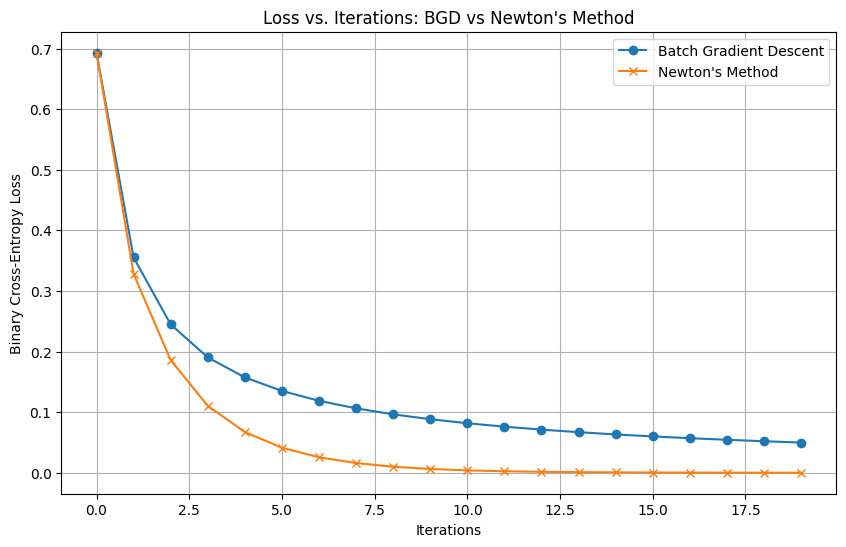

Final BGD Loss after 20 iterations: 0.049863
Final Newton's Method Loss after 20 iterations: 0.000071


In [48]:
# Plot the loss histories for comparison
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Batch Gradient Descent', marker='o')
plt.plot(nm_loss_history, label='Newton\'s Method', marker='x')
plt.title('Loss vs. Iterations: BGD vs Newton\'s Method')
plt.xlabel('Iterations')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend()
plt.grid(True)
plt.show()

# Print final loss values for comparison
print(f"Final BGD Loss after 20 iterations: {loss_history[-1]:.6f}")
print(f"Final Newton's Method Loss after 20 iterations: {nm_loss_history[-1]:.6f}")

Newton's method converges faster than Batch Gradient Descent because:

1. **Second-order information:** Newton's method uses the Hessian matrix, which contains second-order derivative information about the curvature of the loss function. This allows it to adapt the step size based on the local geometry of the loss surface.

2. **Adaptive step sizes:** While BGD uses a fixed learning rate for all parameters, Newton's method effectively computes an adaptive step size for each parameter based on the curvature. It takes larger steps in directions with small curvature and smaller steps in directions with high curvature.

3. **Quadratic convergence:** For well-behaved functions near the optimum, Newton's method exhibits quadratic convergence, meaning the error is squared at each iteration. In contrast, first-order methods like gradient descent have only linear convergence.

4. **Direct path to minimum:** Newton's method finds the direct path to the minimum of a quadratic function in a single step, and since the logistic regression loss function is convex, Newton's method can more efficiently navigate to the minimum by taking more intelligent steps.

The main trade-off is computational complexity. Newton's method requires calculating and inverting the Hessian matrix, which is computationally expensive for high dimensional problems.

6. Two approaches to decide the optimal number of iterations for both methods:

Approach 1: Early Stopping based on Loss Change:
  - Monitor the change in loss function between consecutive iterations
  - Stop when the change falls below a predefined threshold (e.g. $|L(t) - L(t-1)| < \epsilon$)
  - This indicates the algorithm has nearly converged to the optimal solution
  - Different thresholds might be appropriate for BGD (larger) vs. Newton's Method (smaller)




Approach 2: Cross-Validation Performance:
  - Split the data into training and validation sets
  - Train the model with different numbers of iterations
  - Choose the iteration count that minimizes validation error
  - Helps prevent overfitting by stopping when validation performance plateaus


7. When changing the centers from `[[−5, 0], [5, 1.5]]` to `[[2, 2], [5, 1.5]]`, we're modifying the data distribution significantly. Let's visualize and analyze how this change affects the convergence behavior of batch gradient descent.

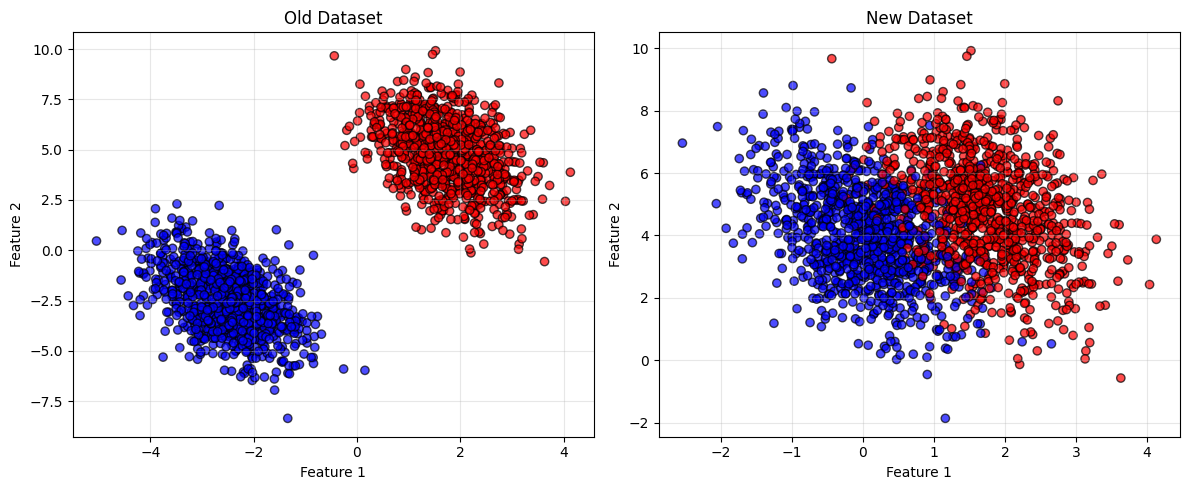

In [49]:
# Generate both datasets for comparison
np.random.seed(0)

# Original dataset centers
original_centers = [[-5, 0], [5, 1.5]]
X_original, y_original = make_blobs(n_samples=2000, centers=original_centers, random_state=5)
X_original = np.dot(X_original, transformation)
y_original = y_original.reshape(-1, 1)

# New dataset with modified centers
new_centers = [[2, 2], [5, 1.5]]
X_new, y_new = make_blobs(n_samples=2000, centers=new_centers, random_state=5)
X_new = np.dot(X_new, transformation)
y_new = y_new.reshape(-1, 1)

# Visualize both datasets
plt.figure(figsize=(12, 5))

# Original dataset
plt.subplot(1, 2, 1)
plt.scatter(X_original[:, 0], X_original[:, 1], c=y_original.ravel(), cmap=plt.cm.bwr, edgecolors='k', alpha=0.7)
plt.title('Old Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, alpha=0.3)

# New dataset
plt.subplot(1, 2, 2)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new.ravel(), cmap=plt.cm.bwr, edgecolors='k', alpha=0.7)
plt.title('New Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Key changes in data distribution are:
1. The distance between class centers has decreased
2. The overlap between classes has increased
3. The decision boundary will be complex to determine

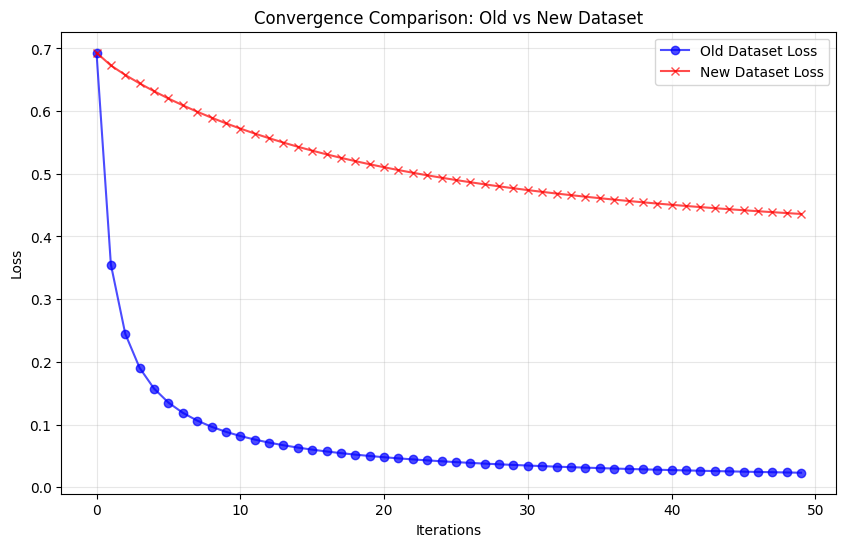

Final loss for original dataset after 50 iterations: 0.023153
Final loss for modified dataset after 50 iterations: 0.435951


In [50]:
# Run batch gradient descent on both datasets with the same parameters
def run_bgd_comparison(X_original, y_original, X_new, y_new, iterations=50, learning_rate=0.1):
    # Original dataset
    weights_original, loss_history_original = batch_gradient_descent(
        X_original, y_original, iterations=iterations, learning_rate=learning_rate
    )
    
    # New dataset
    weights_new, loss_history_new = batch_gradient_descent(
        X_new, y_new, iterations=iterations, learning_rate=learning_rate
    )
    
    return weights_original, loss_history_original, weights_new, loss_history_new

# Run BGD on both datasets
weights_original, loss_history_original, weights_new, loss_history_new = run_bgd_comparison(
    X_original, y_original, X_new, y_new, iterations=50
)

# Plot convergence comparison
plt.figure(figsize=(10, 6))
plt.plot(loss_history_original, 'b-o', label='Old Dataset Loss', alpha=0.7)
plt.plot(loss_history_new, 'r-x', label='New Dataset Loss', alpha=0.7)
plt.title('Convergence Comparison: Old vs New Dataset')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print final loss values
print(f"Final loss for original dataset after 50 iterations: {loss_history_original[-1]:.6f}")
print(f"Final loss for modified dataset after 50 iterations: {loss_history_new[-1]:.6f}")


The change in centers has made significant effects on the convergence behavior.

In the original dataset, the classes were well-separated with centers far apart. In the new dataset, the classes are much closer. This reduced separation of classes made the classification challenging.  
The new dataset shows slower convergence compared to the original dataset because the decision boundary is harder to establish when classes are closer together.  
The final loss for the new dataset is  higher than for the original dataset. This indicates it's harder to perfectly separate the classes with a linear decision boundary. Some data points are likely to be misclassified even with an optimal boundary due to the nature of data distribution.

This behavior demonstrates how the spatial arrangement of data points significantly impacts the difficulty of the classification and the convergence properties of optimization algorithms. When classes are closer together or overlap, gradient-based methods struggle more to find a clear decision boundary, resulting in slower convergence and potentially higher final loss values.